<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/SOA_talk_lognormal_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Future greek without nested stochastics #


## Introduction ##

This jupyter notebook is used to illustrate how to calculate future Greeks without nested stochastics. 
Using a neural network to represent the future Greek is not a new idea. However, previously, we need some kind of approximation of future Greek as training target. With the technique we illustrate in the document, we don’t need to do that.

The inputs of the process are:

* One set of scenario, risk neural or real world
* Cashflows

That's it. We **don’t** need nested scenario, or even shocked scenario.

A neural network is used to represent the delta. The after hedge financial result is calculated for each scenario. The training target is to get the variance of after hedge result as small as possible.

We will use a simple call with lognormal scenarios as an example. The delta calculated by the trained neural network is extremely close to the famed Black Scholes formula. In a sense the neural network rediscovered Black Scholes formula on its own :)

Elsewhere we will have a more complicated example: AAA US equity scenario, a VA like put guarantee with high watermark, higher order hedge and CTE as training target etc.


## The training code


We recommand to run the example on Google Colab. It's free. First, make sure there is a GPU. On Google Colab, there are two type of GPU. One is Tesla K80 and the other is Tesla T4. T4 is more than twice as fast for our training

In [21]:
!nvidia-smi

Fri Aug 30 20:09:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    54W / 149W |   1103MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Update to the latest pytorch package. Pytorch 1.2 incorporated AdamW optimizer, which is an improvement over the regular Adam. Also LBFGS optimizer incorporates strong wolfe line search algo. LBFGS is faster but memory intensive and not as stable. Our neural network is small enough that LBFGS actually works reasonably well. The warming up with AdamW helped with the stability problem.

In [22]:
!pip3 install torch torchvision --upgrade


Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.2.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [23]:
import torch
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.2.0
cuda


### Scenarios and cashflow 


Parameters: one year (252 day) option. Daily hedging. 16% annualized volatility. The risk free rate is 2%. But the drift of the scenario is set to 0%. **The training can recover risk neural delta with real world scenario.** Depending the cashflow logic, we can manipulate the drift to line up with the strike to improve the model convergence.

In [0]:
d=252      #days of simulation
rf=0.02    #risk free rate
sigma=.16  #volatility
drift=0.0  #drift of the scenario

64 batch of 1024 scenarios. 

In [0]:
K1, K2 = 6, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

dt=torch.tensor(1/d,device=device)
sq_dt=torch.sqrt(dt)

s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
  idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)
t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                      
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]
#the chg is discounted to time zero already

Format data for training 

In [0]:
t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

### Delta neural network model

Here is the delta neural network model.  It has two input, time to maturity and index level. There is only one output: delta. There are two middle layer of 16 and 8 nodes. The count of trainable parameter is less than 200. So it is a very small network by modern standard. The result could be improved slightly with a bigger network say two 32 node middle layers. With more than 5 times the trainable parameters, the speed will decrease, but not by 5 times. 

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(2, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

### Training


Use AdamW optimizer

In [28]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.02,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for t in range(200):
    for i in range(N1):
        optimizer.zero_grad()
        delta=model_delta(ts[i])
        delta=delta.view(N2,d)
        asset_gl=torch.sum(delta*chg[i],dim=1)
        hedged_price=asset_gl-pv_payout[i]
        loss=hedged_price.var()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
t2=time.time()
print(t2-t1)

0 9.408540063304827e-05
10 1.6461441191495396e-05
20 1.4481754078587983e-05
30 1.407238687534118e-05
40 1.428889390808763e-05
50 1.5335202988353558e-05
60 1.5757901564938948e-05
70 1.5319097656174563e-05
80 1.4597723748011049e-05
90 1.548040563648101e-05
100 1.510061883891467e-05
110 1.4029354133526795e-05
120 1.3641434634337202e-05
130 1.3998499525769148e-05
140 1.4531934539263602e-05
150 1.5006631656433456e-05
160 1.540159610158298e-05
170 1.56674377649324e-05
180 1.5746687495266087e-05
190 1.565682759974152e-05
133.17772722244263


## Comparison of neural network detla to Black Scholes delta

Standard Black Scholes formulas for call

In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

Chart the difference

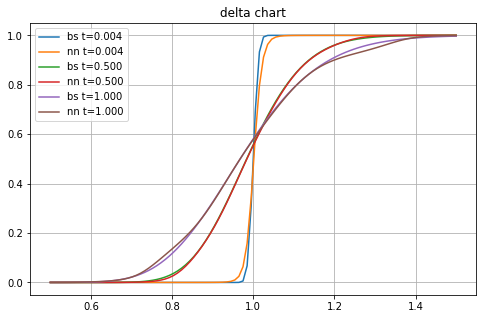

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[.004,.5,1.0]
for t in tl:
  s=torch.linspace(0.5,1.5,100,device=device)
  tsc=torch.zeros((100,2),device=device)
  tsc[:,0]=t
  tsc[:,1]=s
  d_bs=delta_bs(s.cpu().numpy(),1,rf,0,t,sigma)
  d_nn=model_delta(tsc)
  plt.plot(s.cpu().numpy(),d_bs,label="bs t="+ "%.3f" % t)
  plt.plot(s.cpu().numpy(),d_nn.cpu().view(100).detach().numpy(),
           label="nn t="+ "%.3f" % t)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()

Typically we should see the neural network line and Black Scholes line  right on top of each other. For t=0.004 (1 day before the expiration) the slopes of the delta curves are extremely steep. Very often the neural network delta is not as steep. At t=1, the neural network only saw one index level at 1. But typically the neural network delta matches Black Scholes delta over a pretty broad region. This means the model extrapolates well and overfitting is probably not that big a problem.

##Validation

Next, we calculate the hedge effectiveness of training scenario set and a seperate validation scenario set. 

In [31]:
import numpy as np
before_hedge=np.zeros(N1)
after_hedge=np.zeros(N1)
for i in range(N1):
  delta=model_delta(ts[i])
  delta=delta.view(N2,d)
  asset_gl=torch.sum(delta*chg[i],dim=1)
  hedged_price=asset_gl-pv_payout[i]
  loss=hedged_price.var()
  before_hedge[i]=pv_payout[i].std().cpu().item()
  after_hedge[i]=hedged_price.std().cpu().item()
he=1-after_hedge/before_hedge
print("median hedge effectiveness, training set")
print("{:.2%}".format(np.median(he)))

median hedge effectiveness, training set
96.54%


Generate another set of scenario for validation

In [32]:
s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
  idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)

t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                     
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

before_hedge=np.zeros(N1)
after_hedge=np.zeros(N1)
for i in range(N1):
  delta=model_delta(ts[i])
  delta=delta.view(N2,d)
  asset_gl=torch.sum(delta*chg[i],dim=1)
  hedged_price=asset_gl-pv_payout[i]
  loss=hedged_price.var()
  before_hedge[i]=pv_payout[i].std().cpu().item()
  after_hedge[i]=hedged_price.std().cpu().item()
he=1-after_hedge/before_hedge
print("median hedge effectiveness, validation set")
print("{:.2%}".format(np.median(he)))

median hedge effectiveness, validation set
96.49%


Typically the two hedge effectiveness are pretty close to each other. Both at around 96.5%. This further confirms we are not overfitting to the scenarios

## Discussion

## Conclusion